In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("../data/walmart_ml_data.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week,Quarter,Trend,Rolling_mean_5,Rolling_mean_10,Lag_1,Lag_2,Weekly_Sales_detrend,Weekly_Sales_Norm
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,1,1,1125378.184,1159822.43,1643690.90,1643690.90,518312.716,0.0
1,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765,2010,2,5,1,2,1125378.184,1159822.43,1643690.90,1643690.90,518312.716,0.0
2,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554,2010,2,5,1,3,1125378.184,1159822.43,2193048.75,1643690.90,1067670.566,0.0
3,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548,2010,2,5,1,4,1125378.184,1159822.43,536006.73,2193048.75,-589371.454,0.0
4,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324,2010,2,5,1,5,1125378.184,1159822.43,789036.02,536006.73,-336342.164,0.0


In [20]:
X = df.drop(columns=['Date', 'Weekly_Sales', 'Weekly_Sales_detrend', 'Weekly_Sales_Norm'])
y = df['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=42)

print("Train Test Split Completed!")
print(f"Training Set: {len(X_train)} records")
print(f"Testing Set:  {len(X_test)} records")
print(f"Total Records: {len(df)}")

Train Test Split Completed!
Training Set: 4826 records
Testing Set:  1609 records
Total Records: 6435


Defining metrics for evaluation

In [21]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def evaluate(y_true, y_pred):
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return MAE, RMSE, r2

## Bulk training multiple models

Models trained are
1. Linear Regression
2. Light GBM Regressor
3. XGB Regressor
4. Random Forest Regressor

In [22]:
models = {
    "LinearRegression": LinearRegression(),
    "LightGBM": LGBMRegressor(force_row_wise=True),
    "XGB Regressor": XGBRFRegressor(),
    "Random Forest Regressor": RandomForestRegressor()
}

for i in range(len(list(models.values()))):
    model = list(models.values())[i]

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae, train_rmse, train_r2 = evaluate(y_train, y_train_pred)
    test_mae, test_rmse, test_t2 = evaluate(y_test, y_test_pred)

    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(train_mae))
    print("- R2 Score: {:.4f}".format(train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(test_mae))
    print("- R2 Score: {:.4f}".format(test_t2))
    
    print('='*35)
    print('\n')


LinearRegression
Model performance for Training set
- Root Mean Squared Error: 526068.1953
- Mean Absolute Error: 432484.5323
- R2 Score: 0.1580
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 501442.8099
- Mean Absolute Error: 420236.2146
- R2 Score: 0.1260


[LightGBM] [Info] Total Bins 2401
[LightGBM] [Info] Number of data points in the train set: 4826, number of used features: 15
[LightGBM] [Info] Start training from score 1049130.508026
LightGBM
Model performance for Training set
- Root Mean Squared Error: 67583.0281
- Mean Absolute Error: 45557.8162
- R2 Score: 0.9861
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 188770.6053
- Mean Absolute Error: 112419.8194
- R2 Score: 0.8761


XGB Regressor
Model performance for Training set
- Root Mean Squared Error: 231840.1052
- Mean Absolute Error: 152796.8382
- R2 Score: 0.8365
----------------------------------
Model performance for Test set
- Roo

### Inference from bulk training results

Linear Regression performs the worst with R2 score of 0.42 on test set. The evidently shows it is not able to model the non linear relationships in the data.

Light BGM performs the best on both train and test wih R2 score of **0.98** (train) and **0.88** (test). It generalizes well on unseen data with no evidence of major overfitting. This result is before hyperparameter tuning of the model.

## Hyperparameter Tuning of Light GBM

In [23]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.metrics import mean_squared_error
import joblib

cv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    parameters = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "max_bin": trial.suggest_int("max_bin", 100, 500),
    }

    model =LGBMRegressor(**parameters)

    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)

    return -scores.mean()

sampler = TPESampler(seed=42)
pruner = MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=10, timeout=None, show_progress_bar=True)

print("Best value:", study.best_value)
print("Best params:", study.best_params)

best_model = LGBMRegressor(**study.best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test RMSE:", rmse)
print("Test R2:", r2)

# save study and model
joblib.dump(study, "../runs/optuna_lgb_study.pkl")
joblib.dump(best_model, "../models/lgb_best_model.pkl")



[I 2026-01-13 14:31:14,111] A new study created in memory with name: no-name-870d0dd7-d40c-463a-800a-9998c565c754
Best trial: 0. Best value: 238904:  10%|█         | 1/10 [00:10<01:36, 10.75s/it]

[I 2026-01-13 14:31:24,857] Trial 0 finished with value: 238903.60514189862 and parameters: {'n_estimators': 812, 'num_leaves': 123, 'max_bin': 393}. Best is trial 0 with value: 238903.60514189862.


Best trial: 1. Best value: 229368:  20%|██        | 2/10 [00:17<01:07,  8.45s/it]

[I 2026-01-13 14:31:31,702] Trial 1 finished with value: 229367.79723969195 and parameters: {'n_estimators': 1238, 'num_leaves': 33, 'max_bin': 162}. Best is trial 1 with value: 229367.79723969195.


Best trial: 1. Best value: 229368:  30%|███       | 3/10 [00:23<00:50,  7.24s/it]

[I 2026-01-13 14:31:37,504] Trial 2 finished with value: 245185.97636617505 and parameters: {'n_estimators': 210, 'num_leaves': 113, 'max_bin': 341}. Best is trial 1 with value: 229367.79723969195.


Best trial: 3. Best value: 223587:  40%|████      | 4/10 [00:28<00:38,  6.34s/it]

[I 2026-01-13 14:31:42,472] Trial 3 finished with value: 223586.7170580051 and parameters: {'n_estimators': 1446, 'num_leaves': 18, 'max_bin': 488}. Best is trial 3 with value: 223586.7170580051.


Best trial: 3. Best value: 223587:  50%|█████     | 5/10 [00:33<00:29,  5.93s/it]

[I 2026-01-13 14:31:47,666] Trial 4 finished with value: 229467.76660126704 and parameters: {'n_estimators': 1682, 'num_leaves': 39, 'max_bin': 172}. Best is trial 3 with value: 223586.7170580051.


Best trial: 3. Best value: 223587:  60%|██████    | 6/10 [00:35<00:18,  4.54s/it]

[I 2026-01-13 14:31:49,508] Trial 5 finished with value: 243775.77624685905 and parameters: {'n_estimators': 448, 'num_leaves': 50, 'max_bin': 310}. Best is trial 3 with value: 223586.7170580051.


Best trial: 3. Best value: 223587:  70%|███████   | 7/10 [00:38<00:12,  4.15s/it]

[I 2026-01-13 14:31:52,859] Trial 6 finished with value: 242331.93542829723 and parameters: {'n_estimators': 921, 'num_leaves': 48, 'max_bin': 345}. Best is trial 3 with value: 223586.7170580051.


Best trial: 3. Best value: 223587:  80%|████████  | 8/10 [00:39<00:06,  3.22s/it]

[I 2026-01-13 14:31:54,099] Trial 7 finished with value: 231661.18267235492 and parameters: {'n_estimators': 365, 'num_leaves': 49, 'max_bin': 246}. Best is trial 3 with value: 223586.7170580051.


Best trial: 3. Best value: 223587:  90%|█████████ | 9/10 [00:45<00:04,  4.04s/it]

[I 2026-01-13 14:31:59,926] Trial 8 finished with value: 235288.93572962625 and parameters: {'n_estimators': 966, 'num_leaves': 104, 'max_bin': 180}. Best is trial 3 with value: 223586.7170580051.


Best trial: 9. Best value: 220245: 100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


[I 2026-01-13 14:32:04,424] Trial 9 finished with value: 220245.20092844652 and parameters: {'n_estimators': 1077, 'num_leaves': 82, 'max_bin': 118}. Best is trial 9 with value: 220245.20092844652.
Best value: 220245.20092844652
Best params: {'n_estimators': 1077, 'num_leaves': 82, 'max_bin': 118}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 4826, number of used features: 15
[LightGBM] [Info] Start training from score 1049130.508026
Test RMSE: 204199.7459954977
Test R2: 0.855063798692834


['../models/lgb_best_model.pkl']

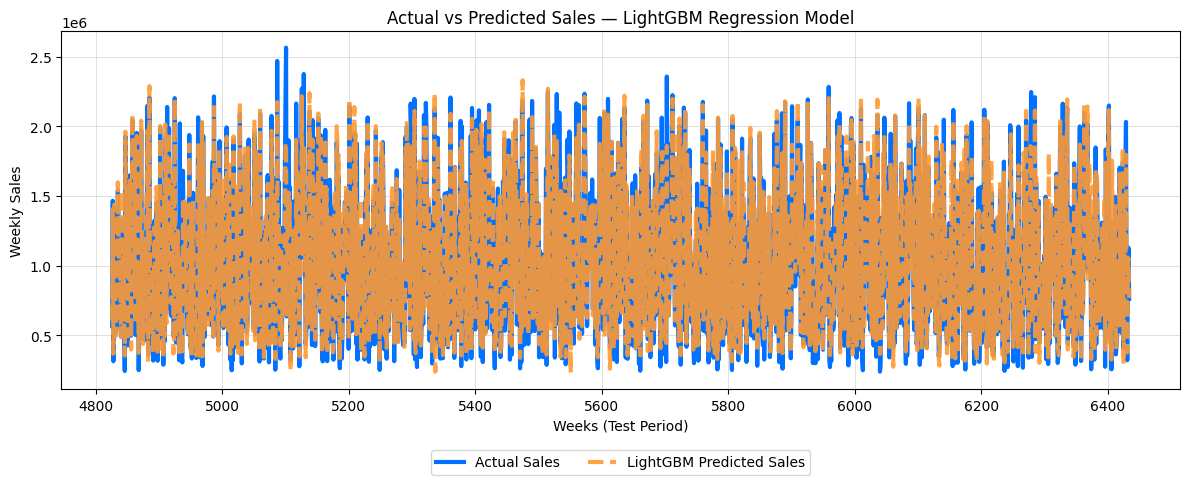

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Use the Series index if available (keeps real dates/weeks on x-axis)
x = y_test.index if hasattr(y_test, "index") else np.arange(len(y_test))

fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.plot(x, y_test.values, label="Actual Sales",
        color="#0072ff", linewidth=3)
ax.plot(x, y_pred, label="LightGBM Predicted Sales",
        color="#FF9933", linewidth=3, linestyle="--", alpha=0.9)

ax.set_title("Actual vs Predicted Sales — LightGBM Regression Model")
ax.set_xlabel("Weeks (Test Period)")
ax.set_ylabel("Weekly Sales")

# place legend centered below the plot (similar to the Plotly layout)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

ax.grid(True, color="lightgrey", linewidth=0.5)
plt.tight_layout()
plt.show()

### Create 12-week forecast and plot

This cell generates `future_df` (12 weekly steps) using the trained `best_model` (or `final_model`), computes an approximate 95% prediction interval from test residuals, and plots historical vs forecasted values. It overwrites `future_df` each run so it's reproducible.


Created future_df with 13 rows (including previous row for continuity).


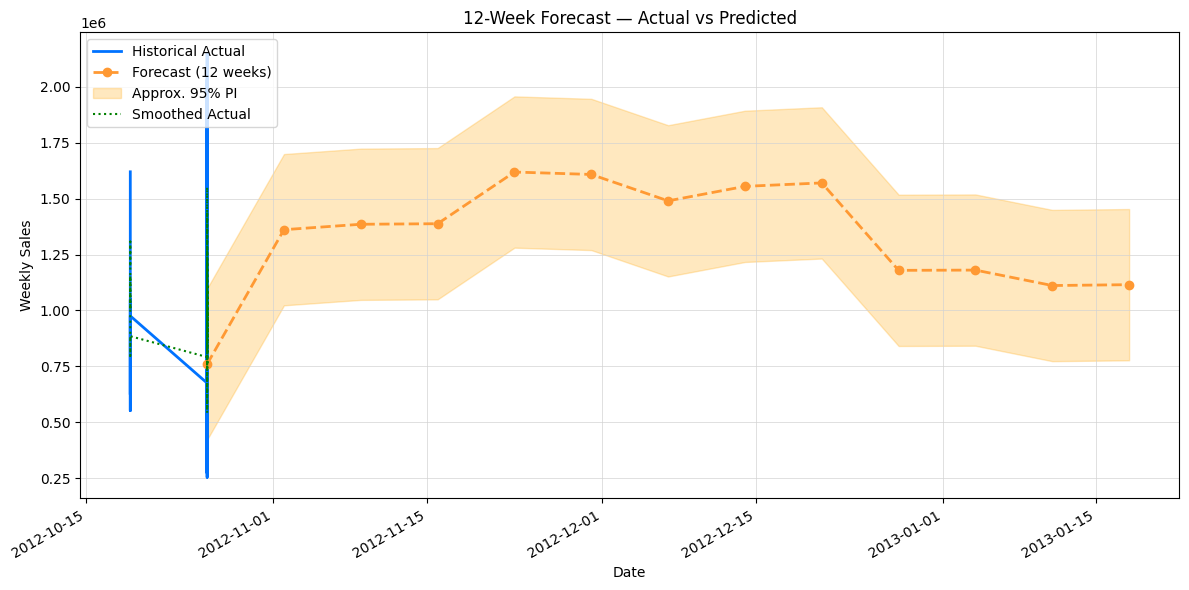

In [9]:
# Build future features for 12 weeks and predict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

STEPS = 12
# prefer the explicitly-named final model if present
_model = best_model
if _model is None:
    raise RuntimeError("No trained model found (expecting 'best_model' or 'final_model'). Run training cell first.")

# ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# prepare X feature ordering (must match what model was trained on)
try:
    X_cols = X_train.columns.tolist()
except Exception:
    X_cols = df.drop(columns=['Date', 'Weekly_Sales']).columns.tolist()

# create forecast rows
last = df.iloc[-1].copy()
forecast_rows = []
for i in range(1, STEPS + 1):
    next_date = last['Date'] + timedelta(days=7)
    row = {}
    for col in X_cols:
        if col == 'year':
            row[col] = next_date.year
        elif col == 'month':
            row[col] = next_date.month
        elif col == 'week':
            row[col] = next_date.isocalendar().week
        elif col == 'Quarter':
            row[col] = (next_date.month - 1) // 3 + 1
        elif col == 'Lag_1':
            row[col] = last.get('Weekly_Sales', last.get('Lag_1', df['Weekly_Sales'].iloc[-1]))
        elif col == 'Lag_2':
            row[col] = last.get('Lag_1', last.get('Lag_2', df['Weekly_Sales'].iloc[-1]))
        elif col in df.columns:
            if df[col].dtype.kind in 'fiu':
                row[col] = float(df[col].mean())
            else:
                # categorical / object: use last known value or mode
                row[col] = last.get(col, df[col].mode().iloc[0] if not df[col].mode().empty else last.get(col, 0))
        else:
            row[col] = last.get(col, 0)

    Xf = pd.DataFrame([row])[X_cols]
    pred = float(_model.predict(Xf)[0])

    row['Weekly_Sales'] = pred
    row['Date'] = next_date
    forecast_rows.append(row)

    # update last for next iteration
    last['Lag_2'] = last.get('Lag_1', last.get('Weekly_Sales', pred))
    last['Lag_1'] = pred
    last['Weekly_Sales'] = pred
    last['Date'] = next_date
    

# assemble future_df and add previous actual row for continuity
future_df = pd.DataFrame(forecast_rows)
if not future_df.empty and not df.empty:
    prev_cols = [c for c in future_df.columns if c in df.columns]
    if prev_cols:
        prev = df.iloc[-1][prev_cols].to_dict()
        prev['Date'] = df.iloc[-1]['Date']
        future_df.loc[-1] = prev
        future_df.index = future_df.index + 1
        future_df = future_df.sort_index().reset_index(drop=True)

print(f"Created future_df with {len(future_df)} rows (including previous row for continuity).")

# prediction interval from test residuals (approximate)
if 'X_test' in globals() and 'y_test' in globals():
    resid_std = (y_test - _model.predict(X_test)).std()
else:
    resid_std = (df['Weekly_Sales'] - df['Weekly_Sales'].rolling(4, min_periods=1).mean()).std()

future_df['lower'] = future_df['Weekly_Sales'] - 1.96 * resid_std
future_df['upper'] = future_df['Weekly_Sales'] + 1.96 * resid_std

# combine and smoothing for context
combined_df = pd.concat([
    df[['Date', 'Weekly_Sales']].assign(Type='Actual'),
    future_df[['Date', 'Weekly_Sales']].assign(Type='Predicted')
], ignore_index=True)
combined_df['Smoothed_Sales'] = combined_df.groupby('Type')['Weekly_Sales'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# plotting
hist = df[['Date', 'Weekly_Sales']].tail(52)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(hist['Date'], hist['Weekly_Sales'], label='Historical Actual', color='#0072ff', linewidth=2)
ax.plot(future_df['Date'], future_df['Weekly_Sales'], label='Forecast (12 weeks)', color='#FF9933', linewidth=2, linestyle='--', marker='o')
ax.fill_between(future_df['Date'], future_df['lower'], future_df['upper'], color='orange', alpha=0.25, label='Approx. 95% PI')

# plot smoothed actuals if present
recent_smoothed = combined_df[(combined_df['Type']=='Actual')].dropna().tail(52)
if not recent_smoothed.empty:
    ax.plot(recent_smoothed['Date'], recent_smoothed['Smoothed_Sales'], label='Smoothed Actual', color='green', linestyle=':')

ax.set_title('12-Week Forecast — Actual vs Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
ax.legend(loc='upper left')
ax.grid(True, color='lightgrey', linewidth=0.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()